In [268]:
import math
import matplotlib.pyplot as plt
import numpy as np

import keras 
import pandas as pd


from keras.models import Sequential
from keras.layers import Dense 

from keras.layers import Dropout

from keras.layers import LSTM

from keras.layers import *


from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

from functools import reduce

In [269]:
composite=pd.read_csv("^IXIC.csv")
composite.drop(composite.tail(1).index,inplace=True)
nas_tech=pd.read_csv("^NDXT.csv")
nas_tech.drop(nas_tech.tail(1).index,inplace=True)
irrate=pd.read_csv("^TNX.csv")
irrate.dropna(inplace=True)
irrate.drop(irrate.tail(1).index,inplace=True)
composite.drop(['Open', 'High', 'Low','Adj Close', 'Volume'], axis=1, inplace=True)
composite.columns = ['Date', 'Comp_Close']
nas_tech.drop(['Open', 'High', 'Low','Adj Close', 'Volume'], axis=1, inplace=True)
nas_tech.columns = ['Date', 'NT_Close']
irrate.drop(['Open', 'High', 'Low','Adj Close', 'Volume'], axis=1, inplace=True)
irrate.columns = ['Date', 'IR_Close']

In [270]:
def merging(df):
  data_frames = [df, composite, nas_tech, irrate]
  df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='inner'), data_frames)
  
  return df_merged

In [271]:
dfa=pd.read_csv("AAPL.csv")

df_merged_a=merging(dfa) 

dfb = pd.read_csv("FB.csv")

df_merged_b = merging(dfb)

dft = pd.read_csv("TESLA.csv")



In [272]:
dft['Date'] =  pd.to_datetime(dft['Date'])

In [273]:
dft['Date'] = dft['Date'].dt.strftime('%Y-%m-%d')

data_frames = [dft, composite, nas_tech, irrate]
df_merged_t = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='inner'), data_frames)
  

In [274]:
df_merged_t.shape

(1249, 10)

Model

In [275]:
model = Sequential()
model.add(GRU(units = 700 , input_shape = (90, 9))) 
model.add(Dropout(0.1))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

APPLE

In [276]:
training_set = df_merged_a.iloc[:1052, 1:].values

test_set = df_merged_a.iloc[1052:, 1:].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

sc_predict = MinMaxScaler(feature_range = (0, 1))
sc_predict.fit_transform(training_set[:, 3].reshape(-1,1))

# Creating a data structure with 90 time-steps and 1 output
X_train90 = []
y_train90 = []
for i in range(90, 1052):
    X_train90.append(training_set_scaled[i-90:i, ])

for i in range(90, 1052):
    y_train90.append(training_set_scaled[i, 3])
X_train90, y_train90 = np.array(X_train90), np.array(y_train90)
X_train90 = np.reshape(X_train90, (X_train90.shape[0], X_train90.shape[1], 9))
X_train90.shape


dataset_train = df_merged_a.iloc[:1052, 1:]
dataset_test = df_merged_a.iloc[1052:, 1:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 90:].values


inputs.shape

inputs = inputs.reshape(-1,9)
inputs = sc.transform(inputs)
len(inputs)

X_test90 = []
for i in range(90, 530):
    X_test90.append(inputs[i-90:i, ])
X_test90 = np.array(X_test90)
X_test90 = np.reshape(X_test90, (X_test90.shape[0], X_test90.shape[1], 9))
print(X_test90.shape)

(440, 90, 9)


In [277]:

model.fit(X_train90, y_train90, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 2s 17ms/step - loss: 0.0371
Epoch 2/30
31/31 [==============================] - 1s 17ms/step - loss: 0.0013
Epoch 3/30
31/31 [==============================] - 1s 17ms/step - loss: 5.9224e-04
Epoch 4/30
31/31 [==============================] - 1s 17ms/step - loss: 9.9112e-04
Epoch 5/30
31/31 [==============================] - 1s 17ms/step - loss: 6.9326e-04
Epoch 6/30
31/31 [==============================] - 1s 17ms/step - loss: 7.2108e-04
Epoch 7/30
31/31 [==============================] - 1s 17ms/step - loss: 5.9249e-04
Epoch 8/30
31/31 [==============================] - 1s 17ms/step - loss: 6.5439e-04
Epoch 9/30
31/31 [==============================] - 1s 17ms/step - loss: 8.6883e-04
Epoch 10/30
31/31 [==============================] - 1s 17ms/step - loss: 4.8414e-04
Epoch 11/30
31/31 [==============================] - 1s 17ms/step - loss: 5.5406e-04
Epoch 12/30
31/31 [==============================] - 1s 17ms/step - loss: 6.6154e-

In [97]:
predicted_stock_price = model.predict(X_test90)
predicted_stock_price = sc_predict.inverse_transform(predicted_stock_price)

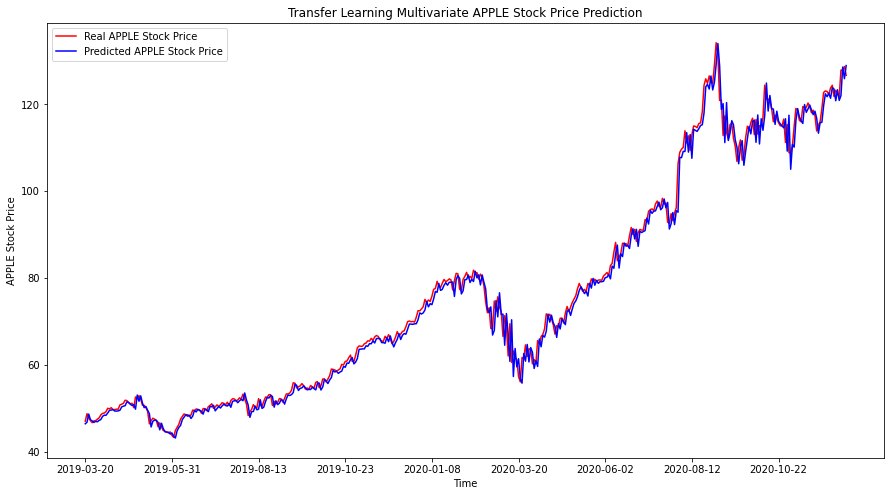

In [98]:
y =  dataset_test['Close'].values.reshape(440,) 
x = df_merged_a.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real APPLE Stock Price")
plt.plot(df_merged_a.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted APPLE Stock Price")
plt.xticks(np.arange(0,440,50))
plt.title('Transfer Learning Multivariate APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.show()

In [99]:
abse = mean_absolute_error(predicted_stock_price,y)
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
print(abse,rmse)

1.5470721595314718 2.2508257053499996


FB

In [278]:
training_set = df_merged_b.iloc[:1052, 1:].values

test_set = df_merged_b.iloc[1052:, 1:].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

sc_predict = MinMaxScaler(feature_range = (0, 1))
sc_predict.fit_transform(training_set[:, 3].reshape(-1,1))

# Creating a data structure with 90 time-steps and 1 output
X_train90 = []
y_train90 = []
for i in range(90, 1052):
    X_train90.append(training_set_scaled[i-90:i, ])

for i in range(90, 1052):
    y_train90.append(training_set_scaled[i, 3])
X_train90, y_train90 = np.array(X_train90), np.array(y_train90)
X_train90 = np.reshape(X_train90, (X_train90.shape[0], X_train90.shape[1], 9))
X_train90.shape

# Getting the predicted stock price of 2017
dataset_train = df_merged_b.iloc[:1052, 1:]
dataset_test = df_merged_b.iloc[1052:, 1:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 90:].values


inputs.shape


inputs = inputs.reshape(-1,9)
inputs = sc.transform(inputs)
len(inputs)


X_test90 = []
for i in range(90, 530):
    X_test90.append(inputs[i-90:i, ])
X_test90 = np.array(X_test90)
X_test90 = np.reshape(X_test90, (X_test90.shape[0], X_test90.shape[1], 9))
print(X_test90.shape)

(440, 90, 9)


In [279]:

model.fit(X_train90, y_train90, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 1s 17ms/step - loss: 8.1874e-04
Epoch 2/30
31/31 [==============================] - 1s 17ms/step - loss: 5.0371e-04
Epoch 3/30
31/31 [==============================] - 1s 16ms/step - loss: 5.3417e-04
Epoch 4/30
31/31 [==============================] - 1s 16ms/step - loss: 6.0707e-04
Epoch 5/30
31/31 [==============================] - 1s 17ms/step - loss: 7.1650e-04
Epoch 6/30
31/31 [==============================] - 1s 17ms/step - loss: 5.0176e-04
Epoch 7/30
31/31 [==============================] - 1s 17ms/step - loss: 5.1314e-04
Epoch 8/30
31/31 [==============================] - 1s 17ms/step - loss: 5.5050e-04
Epoch 9/30
31/31 [==============================] - 1s 17ms/step - loss: 8.1006e-04
Epoch 10/30
31/31 [==============================] - 1s 17ms/step - loss: 4.8577e-04
Epoch 11/30
31/31 [==============================] - 1s 17ms/step - loss: 5.3624e-04
Epoch 12/30
31/31 [==============================] - 1s 17ms/step - loss: 

In [280]:
predicted_stock_price = model.predict(X_test90)
predicted_stock_price = sc_predict.inverse_transform(predicted_stock_price)

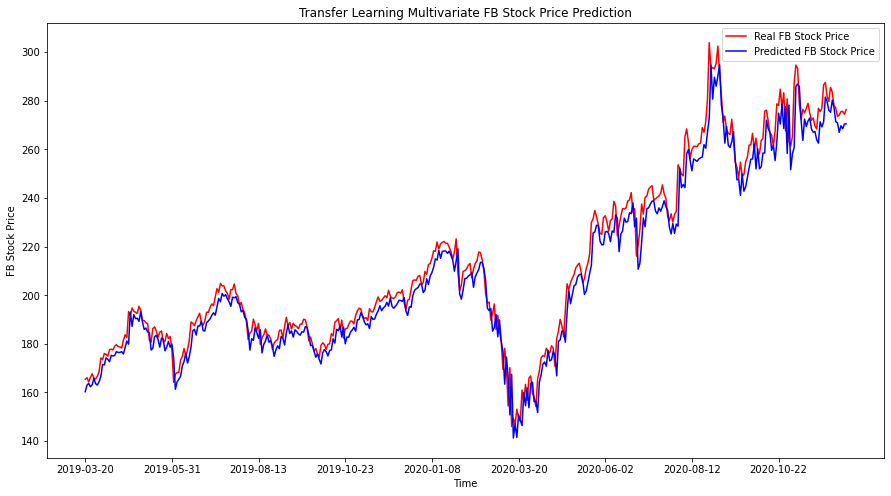

In [281]:
y =  dataset_test['Close'].values.reshape(440,) 
x = df_merged_b.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real FB Stock Price")
plt.plot(df_merged_b.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted FB Stock Price")
plt.xticks(np.arange(0,440,50))
plt.title('Transfer Learning Multivariate FB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show()

In [282]:
abse = mean_absolute_error(predicted_stock_price,y)
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
print(abse,rmse)

5.3284200881924715 6.844172032413991


TESLA

In [258]:
training_set = df_merged_t.iloc[:881, 1:].values

test_set = df_merged_t.iloc[881:, 1:].values

df_merged_t.shape

(1249, 10)

In [259]:

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

sc_predict = MinMaxScaler(feature_range = (0, 1))
sc_predict.fit_transform(training_set[:, 3].reshape(-1,1))

# Creating a data structure with 90 time-steps and 1 output
X_train90 = []
y_train90 = []
for i in range(90, 881):
    X_train90.append(training_set_scaled[i-90:i, ])

for i in range(90, 881):
    y_train90.append(training_set_scaled[i, 3])
X_train90, y_train90 = np.array(X_train90), np.array(y_train90)
X_train90 = np.reshape(X_train90, (X_train90.shape[0], X_train90.shape[1], 9))
X_train90.shape

# Getting the predicted stock price of 2017
dataset_train = df_merged_t.iloc[:881, 1:]
dataset_test = df_merged_t.iloc[881:, 1:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 90:].values


inputs.shape

inputs = inputs.reshape(-1,9)
inputs = sc.transform(inputs)
print(len(inputs))

X_test90 = []
for i in range(90, 458):
    X_test90.append(inputs[i-90:i, ])
X_test90 = np.array(X_test90)
X_test90 = np.reshape(X_test90, (X_test90.shape[0], X_test90.shape[1], 9))
print(X_test90.shape)



458
(368, 90, 9)


In [260]:

model.fit(X_train90, y_train90, epochs = 30, batch_size = 32)

Epoch 1/30
25/25 [==============================] - 2s 17ms/step - loss: 0.1039
Epoch 2/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0033
Epoch 3/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0021
Epoch 4/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0019
Epoch 5/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0017
Epoch 6/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0016
Epoch 7/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0021
Epoch 8/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0016
Epoch 9/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0015
Epoch 10/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0017
Epoch 11/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0017
Epoch 12/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0016
Epoch 13/30
25/25 [==================

In [247]:
predicted_stock_price = model.predict(X_test90)
predicted_stock_price = sc_predict.inverse_transform(predicted_stock_price)
predicted_stock_price.shape

(368, 1)

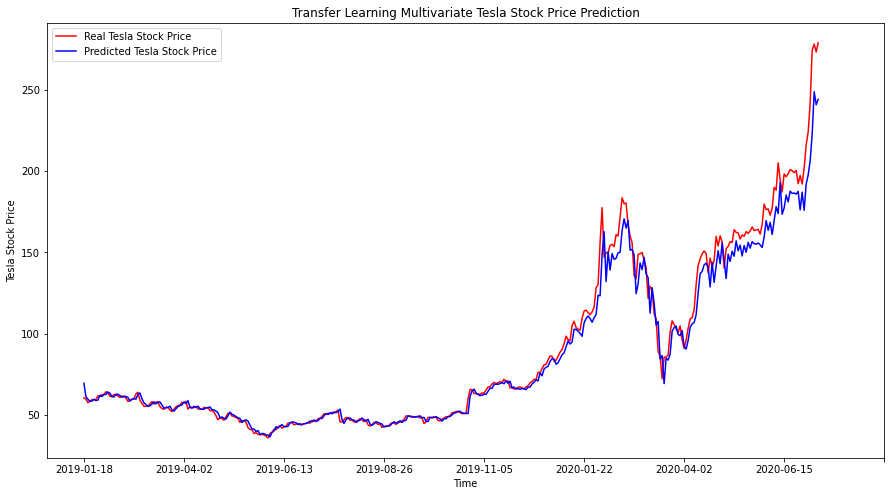

In [248]:
y =  dataset_test['Close'].values.reshape(368,) 
x = df_merged_t.loc[881: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Tesla Stock Price")
plt.plot(df_merged_t.loc[881:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Tesla Stock Price")
plt.xticks(np.arange(0,440,50))
plt.title('Transfer Learning Multivariate Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

In [249]:
abse = mean_absolute_error(predicted_stock_price,y)
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
print(abse,rmse)

4.695728824102651 8.474796830006687
